PART 2: Find a model that explains the data.

For this part you can use any tool you are familiar with, be it statistical methods, machine learning or even deep learning.

Possible ideas:

- regression model if you are trying to predict continuous values
- classification model when you have discrete and finite labels
- clustering if you want to find underlying structures of data, without prior information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
spotify_songs_df = pd.read_csv('spotify-2023.csv', encoding='latin-1')

In [3]:
# Null values in columns of float type
null_float_columns = spotify_songs_df.select_dtypes(include=['float']).isnull().sum()
print("Null values in columns of float type:")
print(null_float_columns)

# Null values in columns of object type
null_text_columns = spotify_songs_df.select_dtypes(include=['object']).isnull().sum()
print("\nNull values in columns of object type:")
print(null_text_columns)

# Null values in columns of integer type
null_int_columns = spotify_songs_df.select_dtypes(include=['int']).isnull().sum()
print("\nNull values in columns of integer type:")
print(null_int_columns)

Null values in columns of float type:
Series([], dtype: float64)

Null values in columns of object type:
track_name              0
artist(s)_name          0
streams                 0
in_deezer_playlists     0
in_shazam_charts       50
key                    95
mode                    0
dtype: int64

Null values in columns of integer type:
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
in_apple_playlists      0
in_apple_charts         0
in_deezer_charts        0
bpm                     0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [4]:
#Converts non-numeric values to NaN
spotify_songs_df['in_shazam_charts'] = pd.to_numeric(spotify_songs_df['in_shazam_charts'], errors='coerce')
#Calculates the average of the numerical values in the column
mean_shazam_charts = spotify_songs_df['in_shazam_charts'].mean()
#Replace the NaN values with the calculated mean
spotify_songs_df['in_shazam_charts'].fillna(mean_shazam_charts, inplace=True)
print("Mean of in_shazam_charts:", mean_shazam_charts)

Mean of in_shazam_charts: 51.176339285714285


In [5]:
spotify_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    object 
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    object 
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      953 non-null    float64
 14  bpm                   953 non-null    int64  
 15  key                   8

To do the model I don't have to consider all the variables but only some, so I prefer to create a copy of the dataframe and use it to do the liner regression and delete some columns that I don't need for the model.

In [6]:
spotify_songs_copy_df = spotify_songs_df.copy()

In [7]:
spotify_songs_copy_df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [8]:
spotify_songs_copy_df.drop(columns= ['track_name', 'artist(s)_name','artist_count','released_year','released_month', 'released_day','in_spotify_playlists', 'in_spotify_charts','in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts','key','mode'], inplace=True)

In [9]:
spotify_songs_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   streams             953 non-null    object
 1   bpm                 953 non-null    int64 
 2   danceability_%      953 non-null    int64 
 3   valence_%           953 non-null    int64 
 4   energy_%            953 non-null    int64 
 5   acousticness_%      953 non-null    int64 
 6   instrumentalness_%  953 non-null    int64 
 7   liveness_%          953 non-null    int64 
 8   speechiness_%       953 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 67.1+ KB


In [10]:
spotify_songs_copy_df.head(3)

,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,141381703,125,80,89,83,31,0,8,4
1,133716286,92,71,61,74,7,0,10,4
2,140003974,138,51,32,53,17,0,31,6


In [11]:
import re
# Function to extract numerical value from a string
def extract_numeric_value(entry):
    if isinstance(entry, str):
        numeric_match = re.search(r'\d+\.*\d*', entry)
        if numeric_match:
            return float(numeric_match.group())
        else:
            return np.nan
    elif isinstance(entry, (int, float)):
        return float(entry)
    else:
        return np.nan

# Applies the function to extract numeric or NaN values from the column
spotify_songs_copy_df['streams_numeric_cleaned'] = spotify_songs_copy_df['streams'].apply(extract_numeric_value)

#  Check the first few lines to see if cleaning was successful
print(spotify_songs_copy_df[['streams', 'streams_numeric_cleaned']].head())

#Function to check whether a string is concatenated (has more than one characteristic type)
def is_concatenated(entry):
    return bool(re.search(r'[A-Za-z]', entry)) and bool(re.search(r'\d', entry))

# Filter and remove rows with concatenated values in the 'streams' column
spotify_songs_copy_df = spotify_songs_copy_df[~spotify_songs_copy_df['streams'].apply(is_concatenated)]


     streams  streams_numeric_cleaned
0  141381703              141381703.0
1  133716286              133716286.0
2  140003974              140003974.0
3  800840817              800840817.0
4  303236322              303236322.0


In [12]:
# Remove the 'streams' column from the DataFrame
spotify_songs_copy_df = spotify_songs_copy_df.drop(columns=['streams'])

In [13]:
spotify_songs_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bpm                      952 non-null    int64  
 1   danceability_%           952 non-null    int64  
 2   valence_%                952 non-null    int64  
 3   energy_%                 952 non-null    int64  
 4   acousticness_%           952 non-null    int64  
 5   instrumentalness_%       952 non-null    int64  
 6   liveness_%               952 non-null    int64  
 7   speechiness_%            952 non-null    int64  
 8   streams_numeric_cleaned  952 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 74.4 KB


In [14]:
x = spotify_songs_copy_df.drop(['streams_numeric_cleaned'], axis = 1) #to make the prediction I delete the column I need to predict
y = spotify_songs_copy_df.streams_numeric_cleaned.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #80% of X and Y are test and 20% are train

In [15]:
ro_scaler = RobustScaler()  #RobustScaler is used to scale features by removing the median and scaling according to the quantile range
x_train_scaled = ro_scaler.fit_transform(x_train)  #fit the scaler on the training data and transform it
x_test_scaled = ro_scaler.fit_transform(x_test)  #apply the same transformation to the test data

In [16]:
model = LinearRegression()  #LinearRegression is a statistical method used to model the relationship between a dependent variable (target) and one or more independent variables (features)
model.fit(x_train_scaled, y_train)  #train the LinearRegression model using the scaled training data

LinearRegression()

In [17]:
y_pred = model.predict(x_test_scaled)  #the .predict() method computes the predicted values of the target variable based on the test features (x_test_scaled)
print(len(y_pred))
y_pred

191


array([6.85159186e+08, 4.04986922e+08, 6.12137716e+08, 4.87241186e+08,
       5.61006431e+08, 4.33785495e+08, 4.96543187e+08, 4.00020246e+08,
       2.93876023e+08, 5.46498500e+08, 5.46075145e+08, 5.67104000e+08,
       5.54238693e+08, 5.35297313e+08, 5.49885519e+08, 6.07888290e+08,
       5.33025403e+08, 6.86237588e+08, 6.51936843e+08, 6.83271781e+08,
       6.07574652e+08, 5.75998206e+08, 6.08198284e+08, 6.60770092e+08,
       5.26736275e+08, 5.00582294e+08, 5.02341036e+08, 5.18993492e+08,
       4.53175358e+08, 5.45584514e+08, 5.71642397e+08, 4.98439402e+08,
       4.90946454e+08, 5.46003481e+08, 6.11099953e+08, 3.68964815e+08,
       5.35867389e+08, 5.46689131e+08, 5.67398844e+08, 4.12901112e+08,
       5.50989438e+08, 4.74656975e+08, 4.69167870e+08, 5.31626059e+08,
       6.50429809e+08, 7.24964968e+08, 5.72450537e+08, 6.04579596e+08,
       4.65940657e+08, 5.65918149e+08, 5.05820968e+08, 6.05786385e+08,
       6.33436145e+08, 5.92517407e+08, 4.41567994e+08, 6.43745081e+08,
      

In [18]:
score = model.score(x_test_scaled, y_test)  #the .score() method computes how well the model's predictions match the actual target values
print("Coefficient of determination (R-squared):", score)

Coefficient of determination (R-squared): -0.00335047079255979


The R-squared score ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no explanatory power. An R-squared value of -0.00335047079255979 indicates that the model is performing poorly, even worse than a simple model that predicts the average target value.

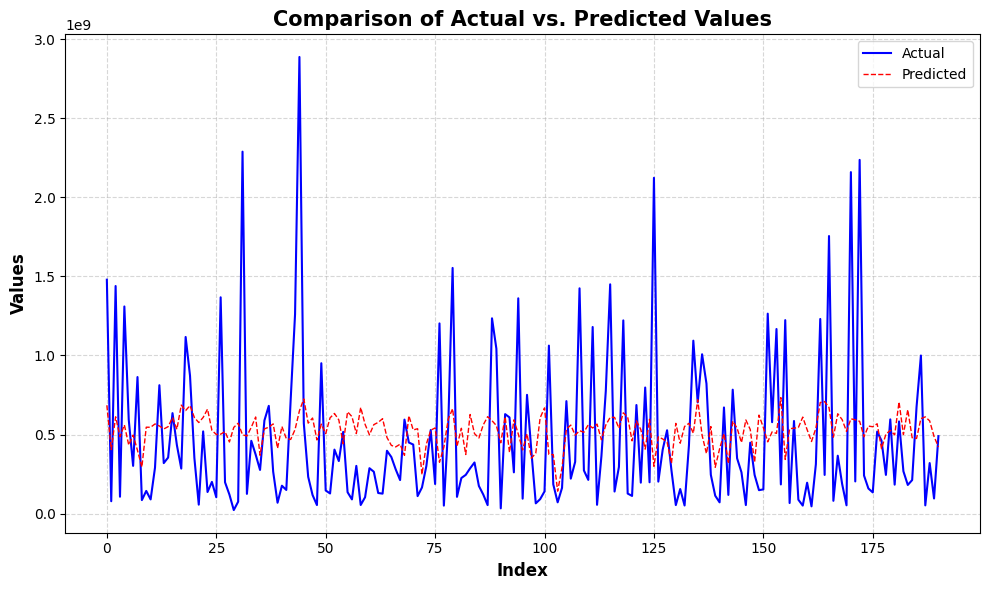

In [19]:
plt.figure(figsize = (10, 6))
plt.plot(y_test, color = 'blue', linewidth = 1.5, label = 'Actual')
plt.plot(y_pred, linestyle = '--', color = 'red', linewidth = 1, label = 'Predicted')
plt.xlabel('Index', fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel('Values', fontsize = 12, fontweight = 'bold', color = 'black')
plt.title('Comparison of Actual vs. Predicted Values', fontsize = 15, fontweight = 'bold', color = 'black')
plt.xticks(fontsize = 10, color = 'black')
plt.yticks(fontsize = 10, color = 'black')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()

Already from the numerical values it could be expected that the graph would be inaccurate. Here it can actually be seen that the actual values are quite discordant with the predicted values.

**PCA Analysis**

In [20]:
#now we have to standardize the columns of this dataframe, the main reason to do this is to garant that all the varaible have the same scale
#but there are other
spotify_songs_copy_df=(spotify_songs_copy_df-spotify_songs_copy_df.mean()/spotify_songs_copy_df.std())

In [21]:
#Inizialize an empty list to store the sum squared of the distance for each number of clusters
Sum_of_squared_distances = []
#Fit the KMeans model to the data with a range of different numbers of clusters
K = range(1,len(spotify_songs_copy_df.columns)+1)
for n in K:
    pca = PCA(n_components=n)
    pca.fit(spotify_songs_copy_df)
    print(n,"components, variance ratio=",pca.explained_variance_ratio_)

1 components, variance ratio= [1.]
2 components, variance ratio= [1.0000000e+00 2.7163083e-15]
3 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15]
4 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15]
5 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715632e-16]
6 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715633e-16 4.80376238e-16]
7 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715632e-16 4.80376238e-16 3.55840518e-16]
8 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715633e-16 4.80376238e-16 3.55840518e-16 2.79493786e-16]
9 components, variance ratio= [1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715633e-16 4.80376238e-16 3.55840518e-16 2.79493786e-16
 2.08248749e-16]


In [22]:
pca = PCA(n_components=len(spotify_songs_copy_df.columns))
pca.fit(spotify_songs_copy_df)

PCA(n_components=9)

**Using PCA to find the correst value of clusters**

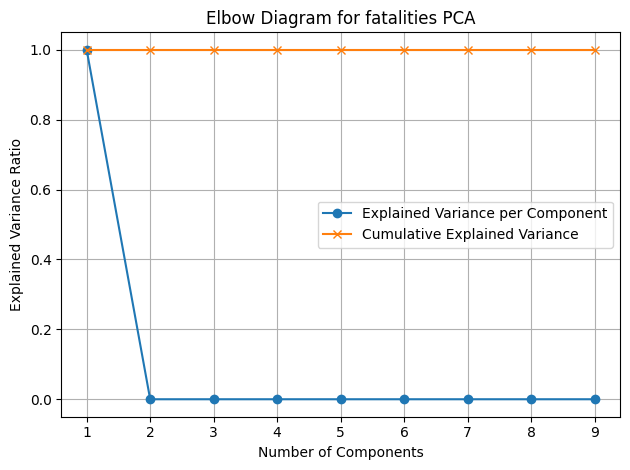

In [23]:
explained_variance=pca.explained_variance_ratio_
cumulative_explained_variance=np.cumsum(pca.explained_variance_ratio_)

plt.plot(K, explained_variance,marker='o', label='Explained Variance per Component')

plt.plot(K, cumulative_explained_variance,marker='x', label='Cumulative Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Diagram for fatalities PCA')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Searching correlation between components of PCA Analysis and the dataset**

In [24]:
print(explained_variance)
print(cumulative_explained_variance)

[1.00000000e+00 2.71630830e-15 2.46802732e-15 1.73176038e-15
 6.46715633e-16 4.80376238e-16 3.55840518e-16 2.79493786e-16
 2.08248749e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
search_for_correlation = spotify_songs_copy_df.copy()


Using a normal distribution to add values in the explained_variance variable to see if there is correlation with the dataset

In [26]:
num_missing_values = len(search_for_correlation) - len(explained_variance)

missing_values = np.random.normal(loc=0, scale=1, size=num_missing_values)

a = missing_values.tolist()
b = explained_variance.tolist()
c = a + b

In [27]:
search_for_correlation['expl_variance'] = c

In [28]:
search_for_correlation_corr = search_for_correlation.corr()

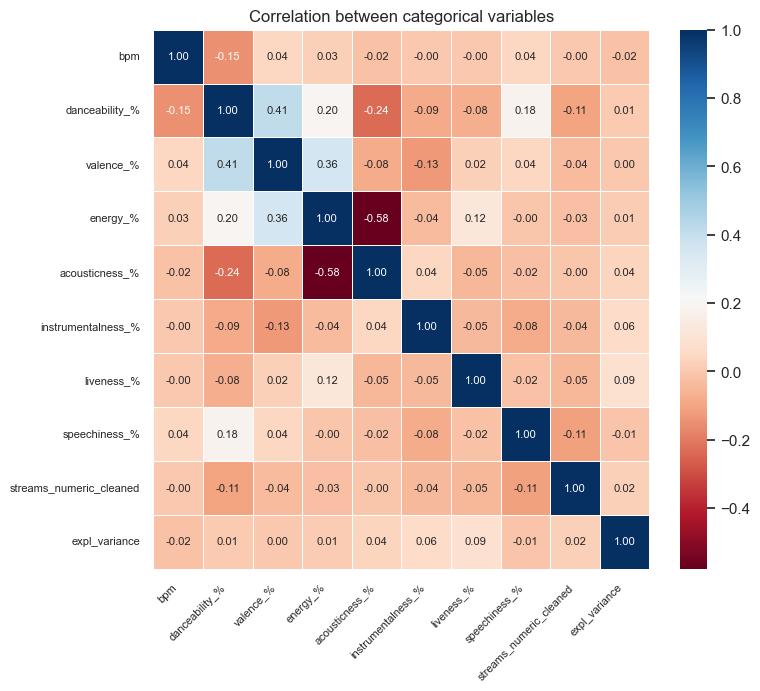

In [29]:
plt.figure(figsize = (8,7))
sns.set(style="whitegrid")
set_color = sns.color_palette("RdBu", as_cmap=True)
heatmap = sns.heatmap(search_for_correlation_corr, annot=True, fmt=".2f", linewidths=.5, annot_kws={"size": 8}, cmap=set_color)
plt.title("Correlation between categorical variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)
plt.xticks(rotation=45, ha="right")
plt.show()


as we can see, there isn't correlation between them

**find best silhouette coefficiente using loops (this is working really good)**

this loop is based on choosing the maximum number of clusters you want by calculating for each individual operation the silhouette index, reporting the best coefficient at the end.

In [30]:
# Set the maximum number of clusters you wish to explore.
max_clusters = 10

# Initialize variables to keep track of the best results:
best_num_clusters = 2  # Start with a reasonable value
best_silhouette_score = -1  # nitialize with an impossible value

# find the value using loop
for num_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=20, n_init=10) # the random state number is arbitrarial but for different tests it has to be the same (centroids locations)
    kmeans_labels = kmeans.fit_predict(spotify_songs_copy_df)
    silhouette_avg = silhouette_score(spotify_songs_copy_df, kmeans_labels)
    
    # Update if the loop find a better solution
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

print(f"The maximum number of clusters with the best silhouette coefficient is: {best_num_clusters}")
print(f"Associated silhouette coeficient: {best_silhouette_score}")

The maximum number of clusters with the best silhouette coefficient is: 2
Associated silhouette coeficient: 0.7415657882310411


**K-means Clustering**

In [32]:
# the aim is to lost less information as possible, reduction the dimansion of the data
pca=PCA(n_components=2)
principal_component=pca.fit_transform(spotify_songs_copy_df)

using only two clusters is in fact a very reductive choice since it is not possible to put all the variables into two macro groups. This choice was made for theoretical purposes only.

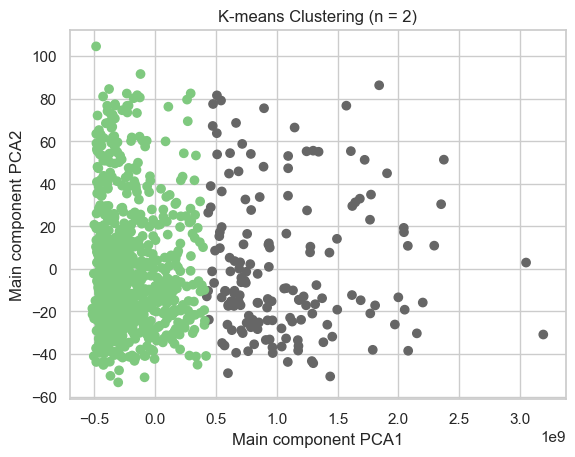

In [33]:
from sklearn.cluster import KMeans

kmeans_2 = KMeans(n_clusters=2, random_state=20, n_init=10)
kmeans_2.fit(spotify_songs_copy_df)
plt.scatter(principal_component[:, 0], principal_component[:, 1], c=kmeans_2.labels_, cmap='Accent')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 2)')
plt.show()

In [34]:
from sklearn.metrics import silhouette_score
print("evaluation for 2 clusters on data:", silhouette_score(spotify_songs_copy_df, kmeans_2.labels_))

evaluation for 2 clusters on data: 0.7415657882310411


using a high value such as 100 or 1000 as the number of clusters, as we can observe, gives a higher silhouette coefficient as the number of clusters increases.

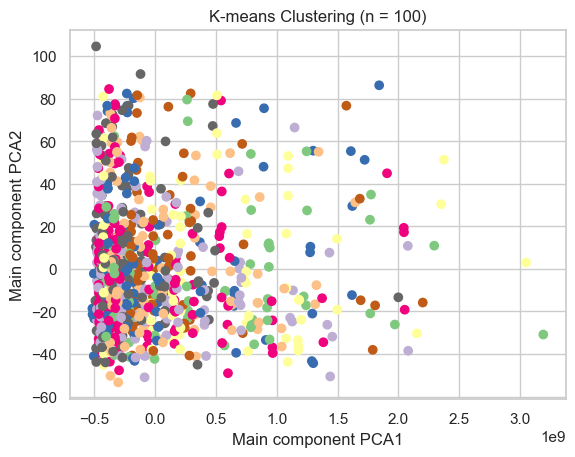

In [35]:
from sklearn.cluster import KMeans

kmeans_100 = KMeans(n_clusters=100, random_state=20, n_init=10)
kmeans_100.fit(spotify_songs_copy_df)
plt.scatter(principal_component[:, 0], principal_component[:, 1], c=kmeans_100.labels_, cmap='Accent')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 100)')
plt.show()

In [36]:
from sklearn.metrics import silhouette_score
print("evaluation for 100 clusters on data:", silhouette_score(spotify_songs_copy_df, kmeans_100.labels_))

evaluation for 100 clusters on data: 0.5543270361773378


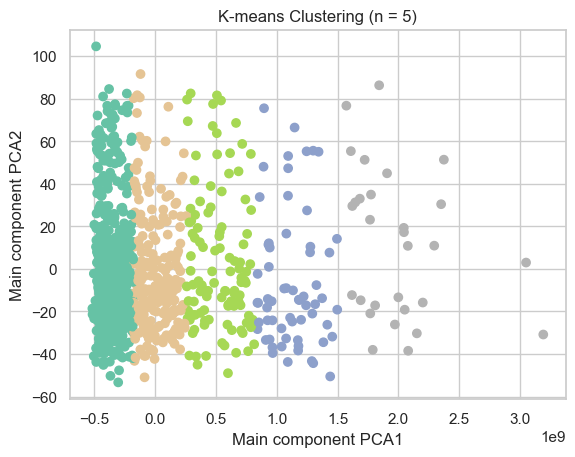

In [37]:
from sklearn.cluster import KMeans

kmeans_5 = KMeans(n_clusters=5, random_state=20, n_init=10)
kmeans_5.fit(spotify_songs_copy_df)
plt.scatter(principal_component[:, 0], principal_component[:, 1], c=kmeans_5.labels_, cmap='Set2')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 5)')
plt.show()

In [38]:
from sklearn.metrics import silhouette_score
print("evaluation for 5 clusters on data:", silhouette_score(spotify_songs_copy_df, kmeans_5.labels_))

evaluation for 5 clusters on data: 0.6035573448882987


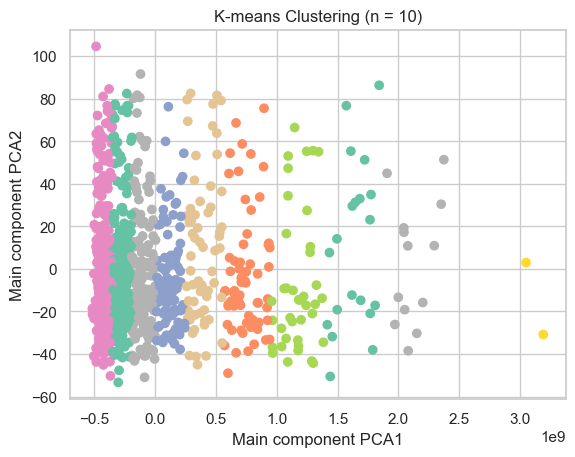

In [40]:
from sklearn.cluster import KMeans

kmeans_10 = KMeans(n_clusters=10, random_state=20, n_init=10)
kmeans_10.fit(spotify_songs_copy_df)
plt.scatter(principal_component[:, 0], principal_component[:, 1], c=kmeans_10.labels_, cmap='Set2')
plt.xlabel('Main component PCA1')
plt.ylabel('Main component PCA2')
plt.title('K-means Clustering (n = 10)')
plt.show()

In [41]:
from sklearn.metrics import silhouette_score
print("evaluation for 10 clusters on data:", silhouette_score(spotify_songs_copy_df, kmeans_10.labels_))

evaluation for 10 clusters on data: 0.5538189819575936
